In [18]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
import os 
from pathlib import Path
import re
import PIL
import cv2
import seaborn as sns 
import copy
import importlib

import spectral_util
importlib.reload(spectral_util)
from spectral_util import *

import fluorescence_util
importlib.reload(fluorescence_util)
from fluorescence_util import *


In [19]:
# 'board.xlsx'
# 'board_noFlux.xlsx'
# 'flux_20240925_184835.xlsx'
# 'flux-onBoard.xlsx'
# 'lead_noFlux.xlsx'

# srcbase = Path("./data/EEM_F-7000_2025-04-11/")
print(Path.cwd())
srcbase = Path("./data/EEM_F-7000_2025-05-29/")
dstdir = Path("./dst/eem/filter")

srcdata = [
    {
        "path": fpath,
        "sample": fpath.stem.split("_")[0],  # 'ABS_20250411' → 'ABS'
        "label": None
    }
    for fpath in srcbase.glob("*.xlsx")
]
srcdata

c:\Users\sawamoto24\sawamoto24\修士研究\microplastic


[{'path': WindowsPath('data/EEM_F-7000_2025-05-29/ABS.xlsx'),
  'sample': 'ABS',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/HDPE.xlsx'),
  'sample': 'HDPE',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/LDPE.xlsx'),
  'sample': 'LDPE',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PC.xlsx'),
  'sample': 'PC',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PET_20250529_150210.xlsx'),
  'sample': 'PET',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PMMA.xlsx'),
  'sample': 'PMMA',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PP.xlsx'),
  'sample': 'PP',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PS.xlsx'),
  'sample': 'PS',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PVC.xlsx'),
  'sample': 'PVC',
  'label': None}]

EEM of "ABS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "HDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "LDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PET"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PMMA"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PP"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PVC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].


<Figure size 640x480 with 0 Axes>

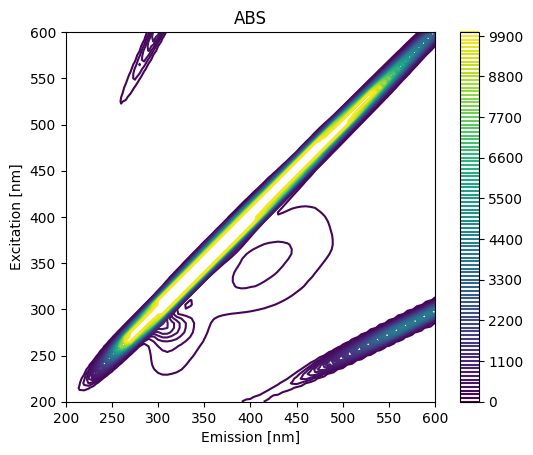

<Figure size 640x480 with 0 Axes>

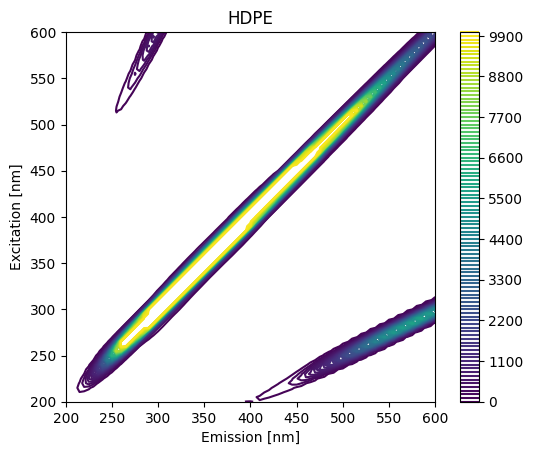

<Figure size 640x480 with 0 Axes>

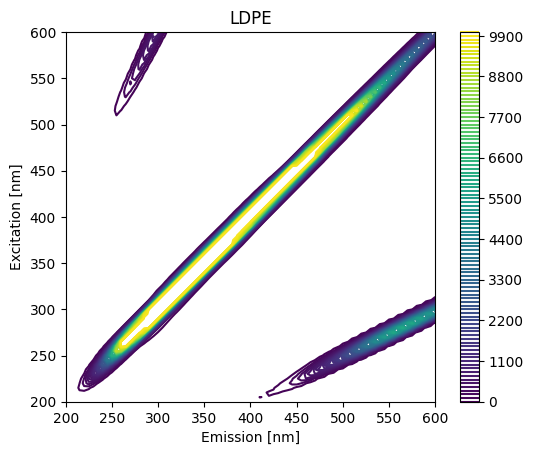

<Figure size 640x480 with 0 Axes>

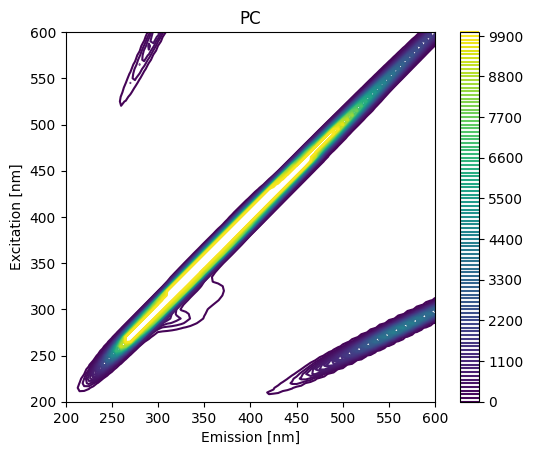

<Figure size 640x480 with 0 Axes>

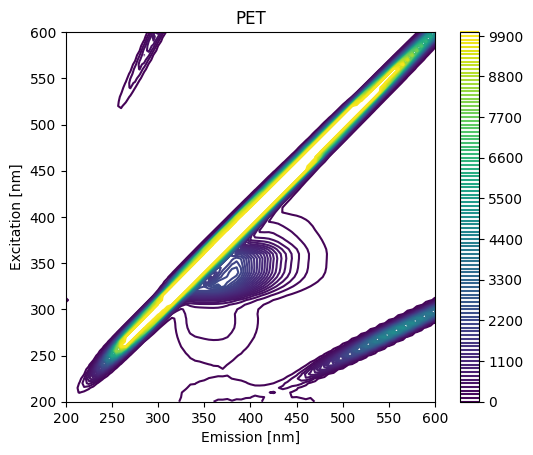

<Figure size 640x480 with 0 Axes>

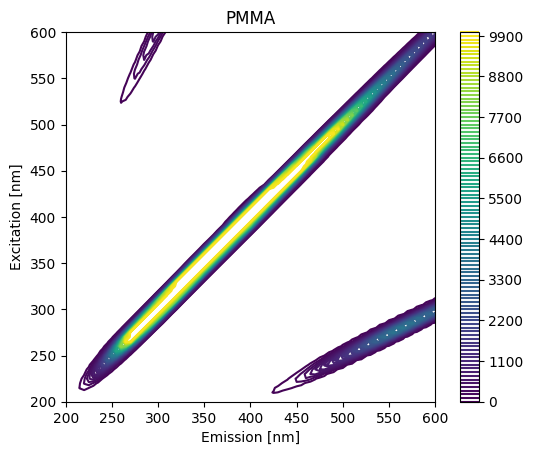

<Figure size 640x480 with 0 Axes>

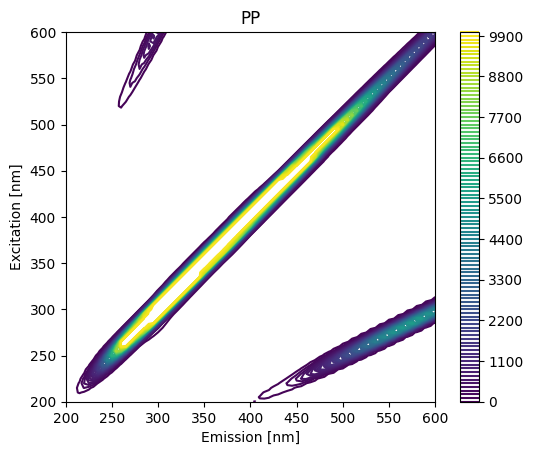

<Figure size 640x480 with 0 Axes>

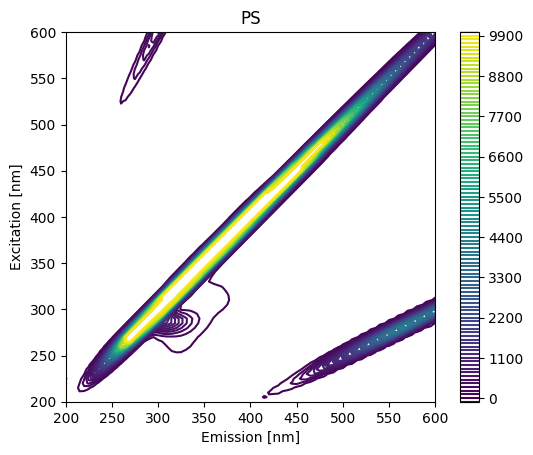

<Figure size 640x480 with 0 Axes>

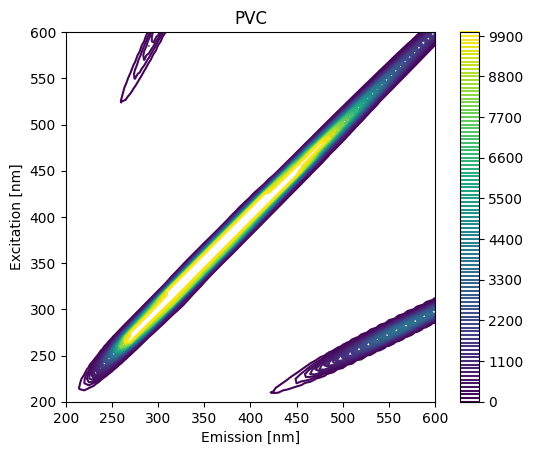

In [20]:
for data in srcdata:
    eem = fluorescence_util.EEMF7000(data.get('path'))
    print(eem)

    plt.figure()
    eem.plot_contour(level=100, show_sample_name=True)

In [21]:
em_bands = eem.em_bands
ex_bands = eem.ex_bands

# 前処理

## 散乱光の除去と波長域の調整

In [22]:
# %% EEMデータの読み込みと前処理（散乱除去 & NaN保持）

sample_data_processed = []
sample_name = []

# 波長域を先に定義しておく
eem_template = fluorescence_util.EEMF7000(srcdata[0]['path'])
ex_bands_full = eem_template.ex_bands
em_bands_full = eem_template.em_bands

# 250nm以上の波長マスクを作成
ex_mask = ex_bands_full >= 250
em_mask = em_bands_full >= 250

# トリミング後の波長域を保存
ex_bands_trimmed = ex_bands_full[ex_mask]
em_bands_trimmed = em_bands_full[em_mask]


print("--- データの前処理を開始します ---")
for data in srcdata:
    # EEMデータの読み込み
    eem = fluorescence_util.EEMF7000(data.get('path'))

    # ① 散乱ピーク除去（NaNを代入）
    eem.remove_self_reflection_and_scattering_from_eem(margin_steps=6,
                                                       remove_first_order=True,
                                                       inplace=True)
    # ② 追加で散乱領域全体を除去（NaNを代入）
    eem.remove_scatter_regions(inplace=True)

    # 生の行列を取得
    eem_matrix = eem.mat

    # ③ 波長域をトリミング
    eem_matrix_trimmed = eem_matrix[np.ix_(ex_mask, em_mask)]

    # 前処理済みのデータをリストに追加
    sample_data_processed.append(eem_matrix_trimmed)
    sample_name.append(eem.sample)
    print(f"  - サンプル '{eem.sample}' の前処理が完了しました。")

print("--- 全ての前処理が完了しました ---")

# リストを3Dのnumpy配列に変換
# この段階ではNaNが含まれている
eem_array_processed = np.array(sample_data_processed)

print("\n処理後のデータ形状:", eem_array_processed.shape)
print("励起波長の数:", len(ex_bands_trimmed))
print("蛍光波長の数:", len(em_bands_trimmed))

--- データの前処理を開始します ---
  - サンプル 'ABS' の前処理が完了しました。
  - サンプル 'HDPE' の前処理が完了しました。
  - サンプル 'LDPE' の前処理が完了しました。
  - サンプル 'PC' の前処理が完了しました。
  - サンプル 'PET' の前処理が完了しました。
  - サンプル 'PMMA' の前処理が完了しました。
  - サンプル 'PP' の前処理が完了しました。
  - サンプル 'PS' の前処理が完了しました。
  - サンプル 'PVC' の前処理が完了しました。
--- 全ての前処理が完了しました ---

処理後のデータ形状: (9, 71, 71)
励起波長の数: 71
蛍光波長の数: 71


In [23]:
sample_name

['ABS', 'HDPE', 'LDPE', 'PC', 'PET', 'PMMA', 'PP', 'PS', 'PVC']

## 正規化

In [24]:
# %% データの正規化（論文準拠: Unit Norm Scaling）

# 正規化済みのデータを格納する新しいリストを作成
sample_data_normalized = []

print("--- データの正規化を開始します（論文準拠）---")
for i, eem_matrix in enumerate(eem_array_processed):
    # NaNを無視して、二乗和を計算
    sum_of_squares = np.nansum(eem_matrix**2)

    # 二乗和が0または非常に小さい場合は、ゼロ除算を避ける
    if sum_of_squares > 1e-8:
        eem_normalized = eem_matrix / sum_of_squares
    else:
        # データが全て0やNaNの場合、そのまま（変更なし）
        eem_normalized = eem_matrix

    sample_data_normalized.append(eem_normalized)
    print(f"  - サンプル '{sample_name[i]}' の正規化が完了しました。")

print("--- 全ての正規化が完了しました ---")

# 正規化後のデータを3Dのnumpy配列に変換
# この段階でもNaNは保持されています
eem_array_normalized = np.array(sample_data_normalized)

print("\n正規化後のデータ形状:", eem_array_normalized.shape)

--- データの正規化を開始します（論文準拠）---
  - サンプル 'ABS' の正規化が完了しました。
  - サンプル 'HDPE' の正規化が完了しました。
  - サンプル 'LDPE' の正規化が完了しました。
  - サンプル 'PC' の正規化が完了しました。
  - サンプル 'PET' の正規化が完了しました。
  - サンプル 'PMMA' の正規化が完了しました。
  - サンプル 'PP' の正規化が完了しました。
  - サンプル 'PS' の正規化が完了しました。
  - サンプル 'PVC' の正規化が完了しました。
--- 全ての正規化が完了しました ---

正規化後のデータ形状: (9, 71, 71)


In [25]:
# %% ステップA: サンプル名とデータの対応を確認

print("--- サンプル名とデータの対応を確認します ---")
print(f"合計サンプル数: {len(sample_name)}")
print("-" * 40)

for i, name in enumerate(sample_name):
    # 対応するデータの形状も一緒に表示
    data_shape = eem_array_normalized[i].shape
    print(f"インデックス {i}: サンプル名 = '{name}', データ形状 = {data_shape}")

print("-" * 40)
print("上記の順番でデータは並んでいます。")

--- サンプル名とデータの対応を確認します ---
合計サンプル数: 9
----------------------------------------
インデックス 0: サンプル名 = 'ABS', データ形状 = (71, 71)
インデックス 1: サンプル名 = 'HDPE', データ形状 = (71, 71)
インデックス 2: サンプル名 = 'LDPE', データ形状 = (71, 71)
インデックス 3: サンプル名 = 'PC', データ形状 = (71, 71)
インデックス 4: サンプル名 = 'PET', データ形状 = (71, 71)
インデックス 5: サンプル名 = 'PMMA', データ形状 = (71, 71)
インデックス 6: サンプル名 = 'PP', データ形状 = (71, 71)
インデックス 7: サンプル名 = 'PS', データ形状 = (71, 71)
インデックス 8: サンプル名 = 'PVC', データ形状 = (71, 71)
----------------------------------------
上記の順番でデータは並んでいます。


In [26]:
# %% ステップA: サンプル名とデータの対応を確認

print("--- サンプル名とデータの対応を確認します ---")
print(f"合計サンプル数: {len(sample_name)}")
print("-" * 40)

for i, name in enumerate(sample_name):
    # 対応するデータの形状も一緒に表示
    data_shape = eem_array_normalized[i].shape
    print(f"インデックス {i}: サンプル名 = '{name}', データ形状 = {data_shape}")

print("-" * 40)
print("上記の順番でデータは並んでいます。")

--- サンプル名とデータの対応を確認します ---
合計サンプル数: 9
----------------------------------------
インデックス 0: サンプル名 = 'ABS', データ形状 = (71, 71)
インデックス 1: サンプル名 = 'HDPE', データ形状 = (71, 71)
インデックス 2: サンプル名 = 'LDPE', データ形状 = (71, 71)
インデックス 3: サンプル名 = 'PC', データ形状 = (71, 71)
インデックス 4: サンプル名 = 'PET', データ形状 = (71, 71)
インデックス 5: サンプル名 = 'PMMA', データ形状 = (71, 71)
インデックス 6: サンプル名 = 'PP', データ形状 = (71, 71)
インデックス 7: サンプル名 = 'PS', データ形状 = (71, 71)
インデックス 8: サンプル名 = 'PVC', データ形状 = (71, 71)
----------------------------------------
上記の順番でデータは並んでいます。


---

# 妥当性評価


--- レバレッジをプロットします ---


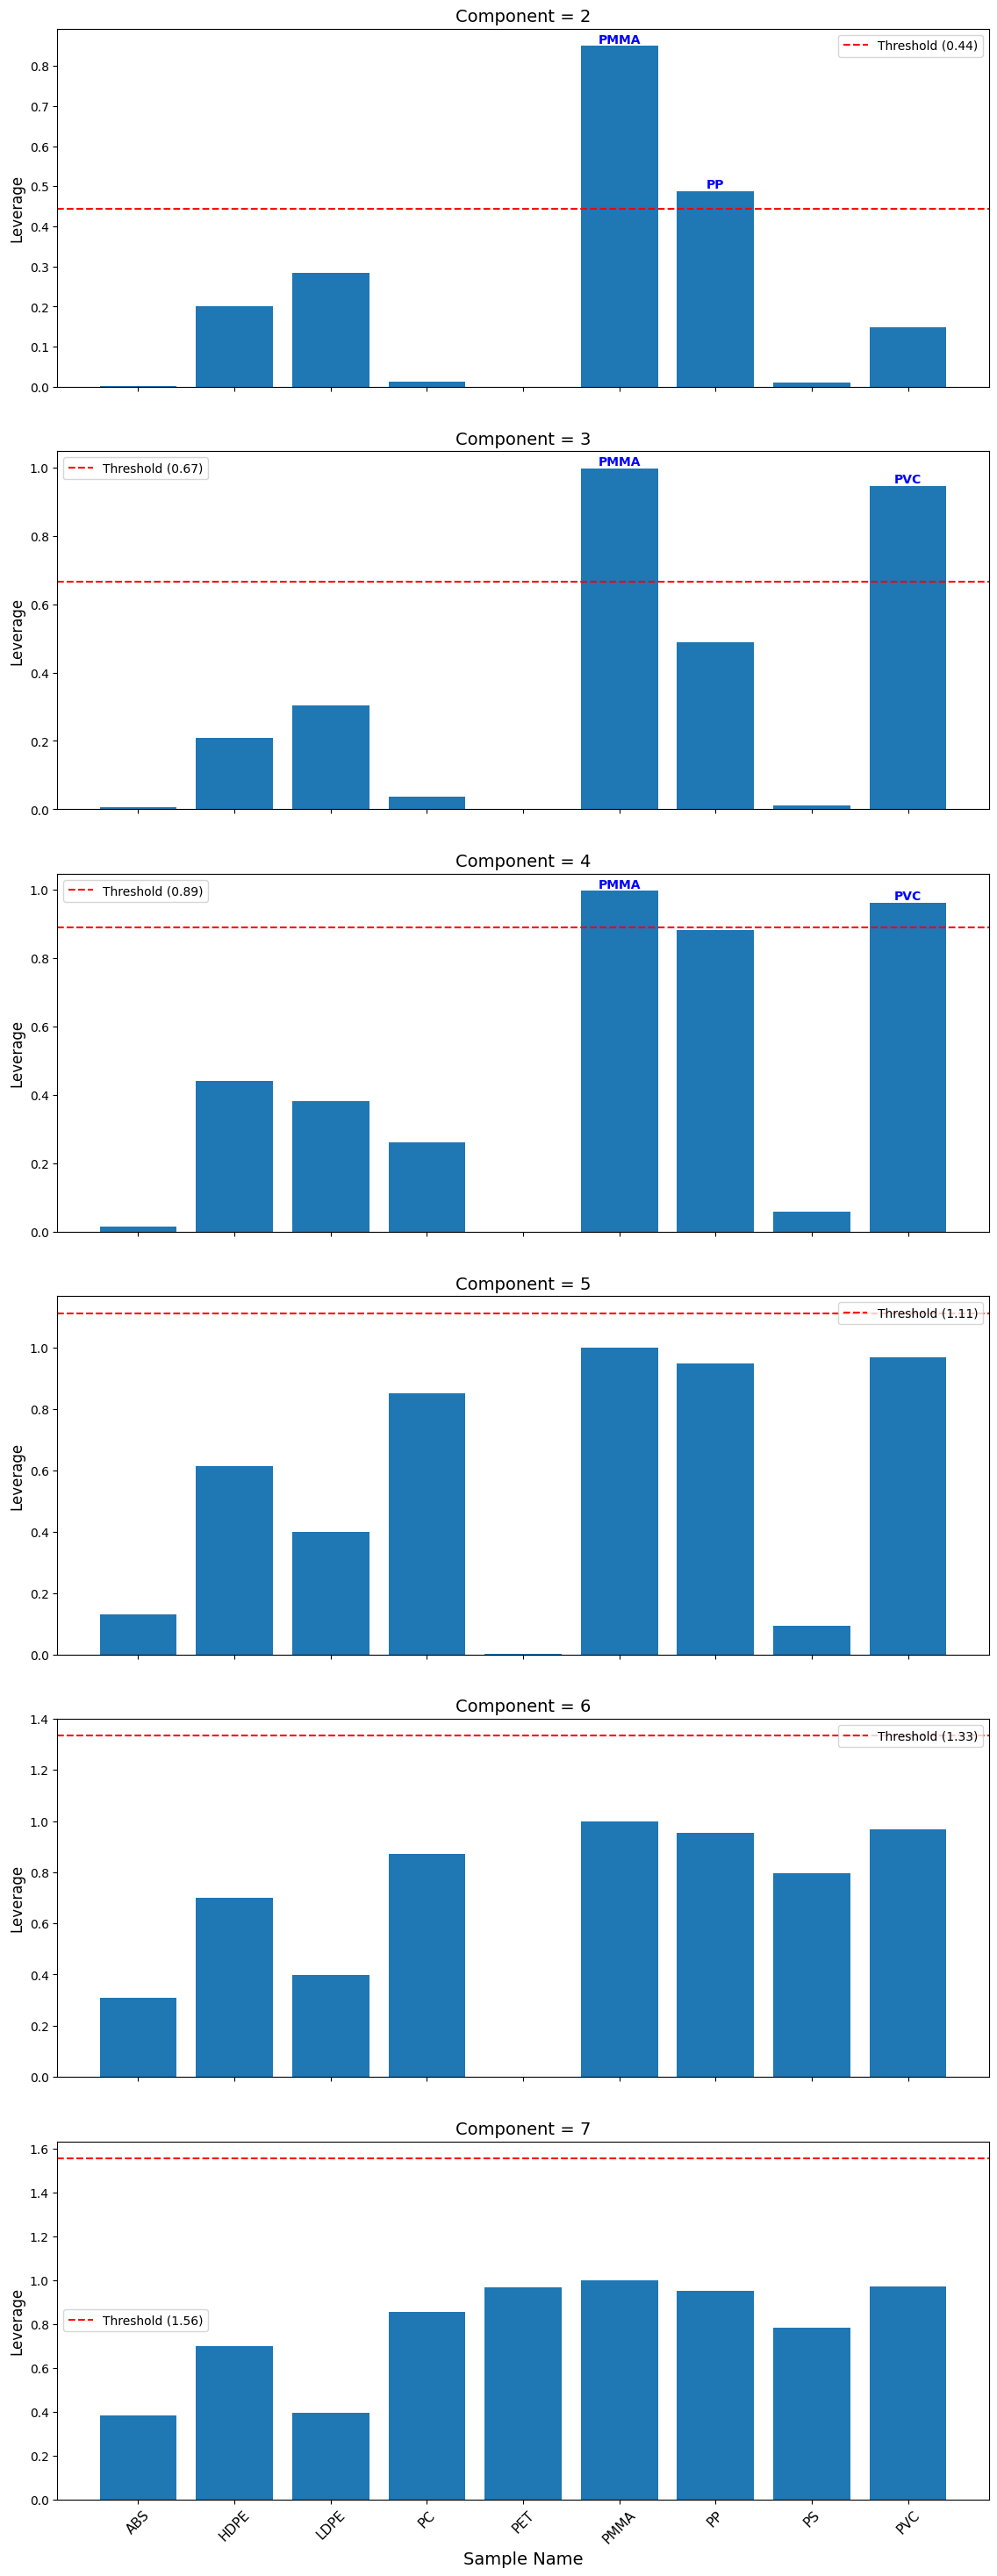

In [27]:
# %% ステップB: 横軸を見やすくしたレバレッジプロット（レイアウト調整版）

import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import numpy as np
import matplotlib.pyplot as plt

# --- この部分は変更ありません ---
eem_array_imputed = np.nan_to_num(eem_array_normalized, nan=0.0)
tensor = tl.tensor(np.transpose(eem_array_imputed, (1, 2, 0)))
max_components = 7
component_range = range(2, max_components + 1)
leverage_results = {}
for n_comp in component_range:
    weights, factors = non_negative_parafac(tensor,
                                            rank=n_comp, n_iter_max=200,
                                            tol=1e-6, init='random')
    sample_scores = factors[2]
    try:
        q, _ = np.linalg.qr(sample_scores)
        leverage = np.sum(q**2, axis=1)
        leverage_results[n_comp] = leverage
    except np.linalg.LinAlgError:
        leverage_results[n_comp] = np.full(tensor.shape[2], np.nan)
# --- ここまで変更なし ---


# --- 結果の可視化（レイアウト調整版） ---
print("\n--- レバレッジをプロットします ---")

# ▼▼▼ グラフ全体のサイズを、より縦長に調整 ▼▼▼
fig, axes = plt.subplots(len(component_range), 1, figsize=(12, 5 * len(component_range)), sharex=True)
if len(component_range) == 1:
    axes = [axes]

for i, n_comp in enumerate(component_range):
    ax = axes[i]
    leverage = leverage_results.get(n_comp)
    if leverage is not None and not np.isnan(leverage).all():
        bars = ax.bar(sample_name, leverage)
        ax.set_ylabel("Leverage", fontsize=12)
        ax.set_title(f"Component = {n_comp}", fontsize=14)
        ax.tick_params(axis='x', rotation=45, labelsize=11)
        ax.tick_params(axis='y', labelsize=10) # y軸のラベルサイズも調整

        threshold = 2 * n_comp / tensor.shape[2]
        ax.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
        ax.legend()

        for bar, name, lev_val in zip(bars, sample_name, leverage):
            if lev_val > threshold:
                ax.text(bar.get_x() + bar.get_width() / 2, lev_val, name,
                        ha='center', va='bottom', fontsize=10, color='blue', weight='bold')
    else:
        ax.set_title(f"Component = {n_comp} (Calculation Failed)")

plt.xlabel("Sample Name", fontsize=14)

# ▼▼▼ 各プロット間の余白をしっかり確保する命令を追加 ▼▼▼
# pad=3.0 で、各グラフの周囲に十分なスペースを確保します
fig.tight_layout(pad=3.0)

plt.show()

## core consistency

--- コアコンシステンシーの計算を開始します (手動計算) ---
  - 成分数 = 1 でモデルを構築中...
  - 成分数 = 1 のコアコンシステンシー: 100.0%
  - 成分数 = 2 でモデルを構築中...
  - 成分数 = 2 のコアコンシステンシー: 92.9%
  - 成分数 = 3 でモデルを構築中...
  - 成分数 = 3 のコアコンシステンシー: 66.5%
  - 成分数 = 4 でモデルを構築中...
  - 成分数 = 4 のコアコンシステンシー: 11.2%
  - 成分数 = 5 でモデルを構築中...
  - 成分数 = 5 のコアコンシステンシー: 7.9%
  - 成分数 = 6 でモデルを構築中...
  - 成分数 = 6 のコアコンシステンシー: 25.1%
  - 成分数 = 7 でモデルを構築中...
  - 成分数 = 7 のコアコンシステンシー: 10.0%
--- 計算が完了しました ---


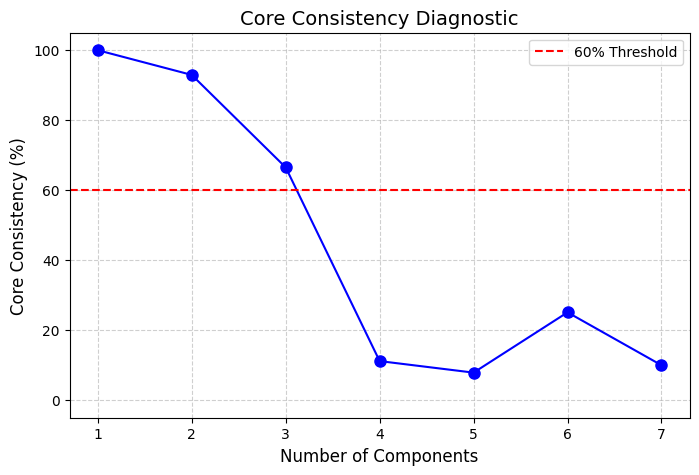

In [28]:
# %% コアコンシステンシーの手動計算とプロット

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from tensorly.tenalg import multi_mode_dot

# --- 事前準備（これまでのステップで準備した変数） ---
# eem_array_normalized: 正規化済みでNaNを含むデータ配列
# -----------------------------------------------

# NaNを0で埋めた正規化済みデータ
eem_array_imputed = np.nan_to_num(eem_array_normalized, nan=0.0)
# テンソルに変換 (励起, 蛍光, サンプル)
tensor = tl.tensor(np.transpose(eem_array_imputed, (1, 2, 0)))

# 試行する成分数の範囲
max_components = 7
component_range = range(1, max_components + 1)


print("--- コアコンシステンシーの計算を開始します (手動計算) ---")
core_consistencies = []

for n_comp in component_range:
    print(f"  - 成分数 = {n_comp} でモデルを構築中...")
    weights, factors = non_negative_parafac(tensor, rank=n_comp, n_iter_max=200,
                                            tol=1e-6, init='random')
    
    # --- コアコンシステンシーの手動計算 ---
    # 1. ローディング行列から、擬似逆行列を計算
    pseudo_inverses = [np.linalg.pinv(f) for f in factors]
    
    # 2. 現実のコアテンソル（G）を計算
    # G = X * (A^-1, B^-1, C^-1)
    core_tensor_G = multi_mode_dot(tensor, pseudo_inverses, modes=[0, 1, 2])

    # 3. 理想のコアテンソル（T）を作成（対角成分が1、他が0）
    ideal_core_T = tl.zeros_like(core_tensor_G)
    for i in range(n_comp):
        ideal_core_T[i, i, i] = 1
        
    # 4. コアテンソルGの全要素の二乗和 (ssq_G) を計算
    ssq_G = tl.sum(core_tensor_G**2)
    
    # 5. GとTの差の二乗和 (ssq_diff) を計算
    ssq_diff = tl.sum((core_tensor_G - ideal_core_T)**2)
    
    # 6. コアコンシステンシーを計算
    # 100 * (1 - (GとTの差の二乗和) / (Gの全要素の二乗和))
    if ssq_G > 1e-8: # ゼロ除算を避ける
        cc = (1 - (ssq_diff / ssq_G)) * 100
    else:
        cc = 0
        
    core_consistencies.append(cc)
    print(f"  - 成分数 = {n_comp} のコアコンシステンシー: {cc:.1f}%")

print("--- 計算が完了しました ---")

# --- 結果のプロット ---
plt.figure(figsize=(8, 5))
plt.plot(component_range, core_consistencies, 'o-', color='b', markersize=8)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Core Consistency (%)", fontsize=12)
plt.title("Core Consistency Diagnostic", fontsize=14)
plt.xticks(component_range)
plt.grid(True, linestyle='--', alpha=0.6)
# 60%のラインに補助線を追加
plt.axhline(y=60, color='r', linestyle='--', label='60% Threshold')
plt.legend()
plt.ylim(-5, 105) # 負の値も表示できるように調整
plt.show()

## split-half

--- スプリットハーフ分析を開始します ---

--- 成分数 = 2 で分析中... ---
  - 成分数 = 2 の平均類似度: 86.4%

--- 成分数 = 3 で分析中... ---
  - 成分数 = 3 の平均類似度: 80.9%

--- 成分数 = 4 で分析中... ---
  - 成分数 = 4 の平均類似度: 77.0%

--- 成分数 = 5 で分析中... ---
  - 成分数 = 5 の平均類似度: 44.7%

--- 成分数 = 6 で分析中... ---
  - 成分数 = 6 の平均類似度: 78.1%

--- 成分数 = 7 で分析中... ---
  - 成分数 = 7 の平均類似度: 78.9%
--- 分析が完了しました ---


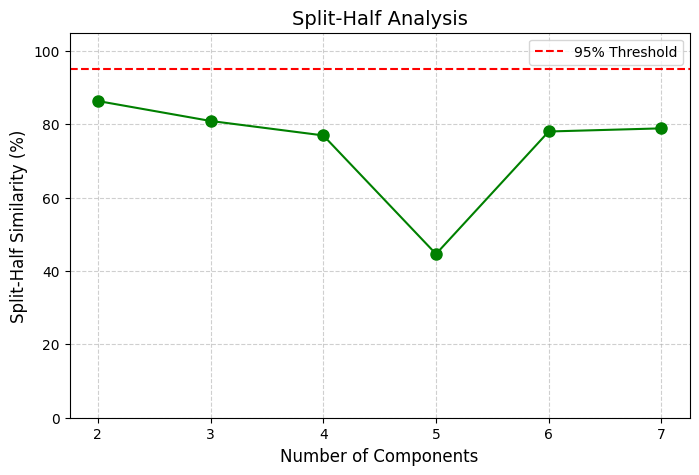

In [29]:
# %% スプリットハーフ分析

import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --- 事前準備（これまでのステップで準備した変数） ---
# eem_array_normalized: 正規化済みでNaNを含むデータ配列
# -----------------------------------------------

# NaNを0で埋めた正規化済みデータ
eem_array_imputed = np.nan_to_num(eem_array_normalized, nan=0.0)
# テンソルに変換 (励起, 蛍光, サンプル)
tensor = tl.tensor(np.transpose(eem_array_imputed, (1, 2, 0)))
num_samples = tensor.shape[2]


# 試行する成分数の範囲
max_components = 7
component_range = range(2, max_components + 1)

print("--- スプリットハーフ分析を開始します ---")
similarity_scores = []

for n_comp in component_range:
    print(f"\n--- 成分数 = {n_comp} で分析中... ---")
    
    # 1. データセットをランダムに半分に分割
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    half1_indices = indices[:num_samples // 2]
    half2_indices = indices[num_samples // 2:]
    
    tensor_half1 = tl.tensor(tensor[:, :, half1_indices])
    tensor_half2 = tl.tensor(tensor[:, :, half2_indices])
    
    # 2. それぞれの半分でPARAFACを実行
    _, factors1 = non_negative_parafac(tensor_half1, rank=n_comp, n_iter_max=200, tol=1e-6, init='random')
    _, factors2 = non_negative_parafac(tensor_half2, rank=n_comp, n_iter_max=200, tol=1e-6, init='random')
    
    # 3. ローディングを比較
    excitation_loadings1, emission_loadings1, _ = factors1
    excitation_loadings2, emission_loadings2, _ = factors2
    
    # 類似度を計算 (最適なペアを見つけてマッチング)
    total_similarity = 0
    matched_indices2 = []
    
    for i in range(n_comp):
        best_match_idx = -1
        max_corr = -1
        for j in range(n_comp):
            if j in matched_indices2:
                continue
            corr_ex, _ = pearsonr(excitation_loadings1[:, i], excitation_loadings2[:, j])
            corr_em, _ = pearsonr(emission_loadings1[:, i], emission_loadings2[:, j])
            avg_corr = (corr_ex + corr_em) / 2
            
            if avg_corr > max_corr:
                max_corr = avg_corr
                best_match_idx = j
        
        total_similarity += max_corr
        matched_indices2.append(best_match_idx)
        
    avg_similarity = total_similarity / n_comp
    similarity_scores.append(avg_similarity * 100) # パーセントに変換
    print(f"  - 成分数 = {n_comp} の平均類似度: {avg_similarity*100:.1f}%")

print("--- 分析が完了しました ---")

# --- 結果のプロット ---
plt.figure(figsize=(8, 5))
plt.plot(component_range, similarity_scores, 'o-', color='g', markersize=8)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Split-Half Similarity (%)", fontsize=12)
plt.title("Split-Half Analysis", fontsize=14)
plt.xticks(component_range)
plt.grid(True, linestyle='--', alpha=0.6)
# 95%のラインに補助線を追加
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.ylim(0, 105)
plt.show()

## 可視化

--- 最適な成分数 = 9 で最終モデルを構築します ---
--- モデル構築完了 ---

--- 抽出された成分のスペクトルをプロットします ---


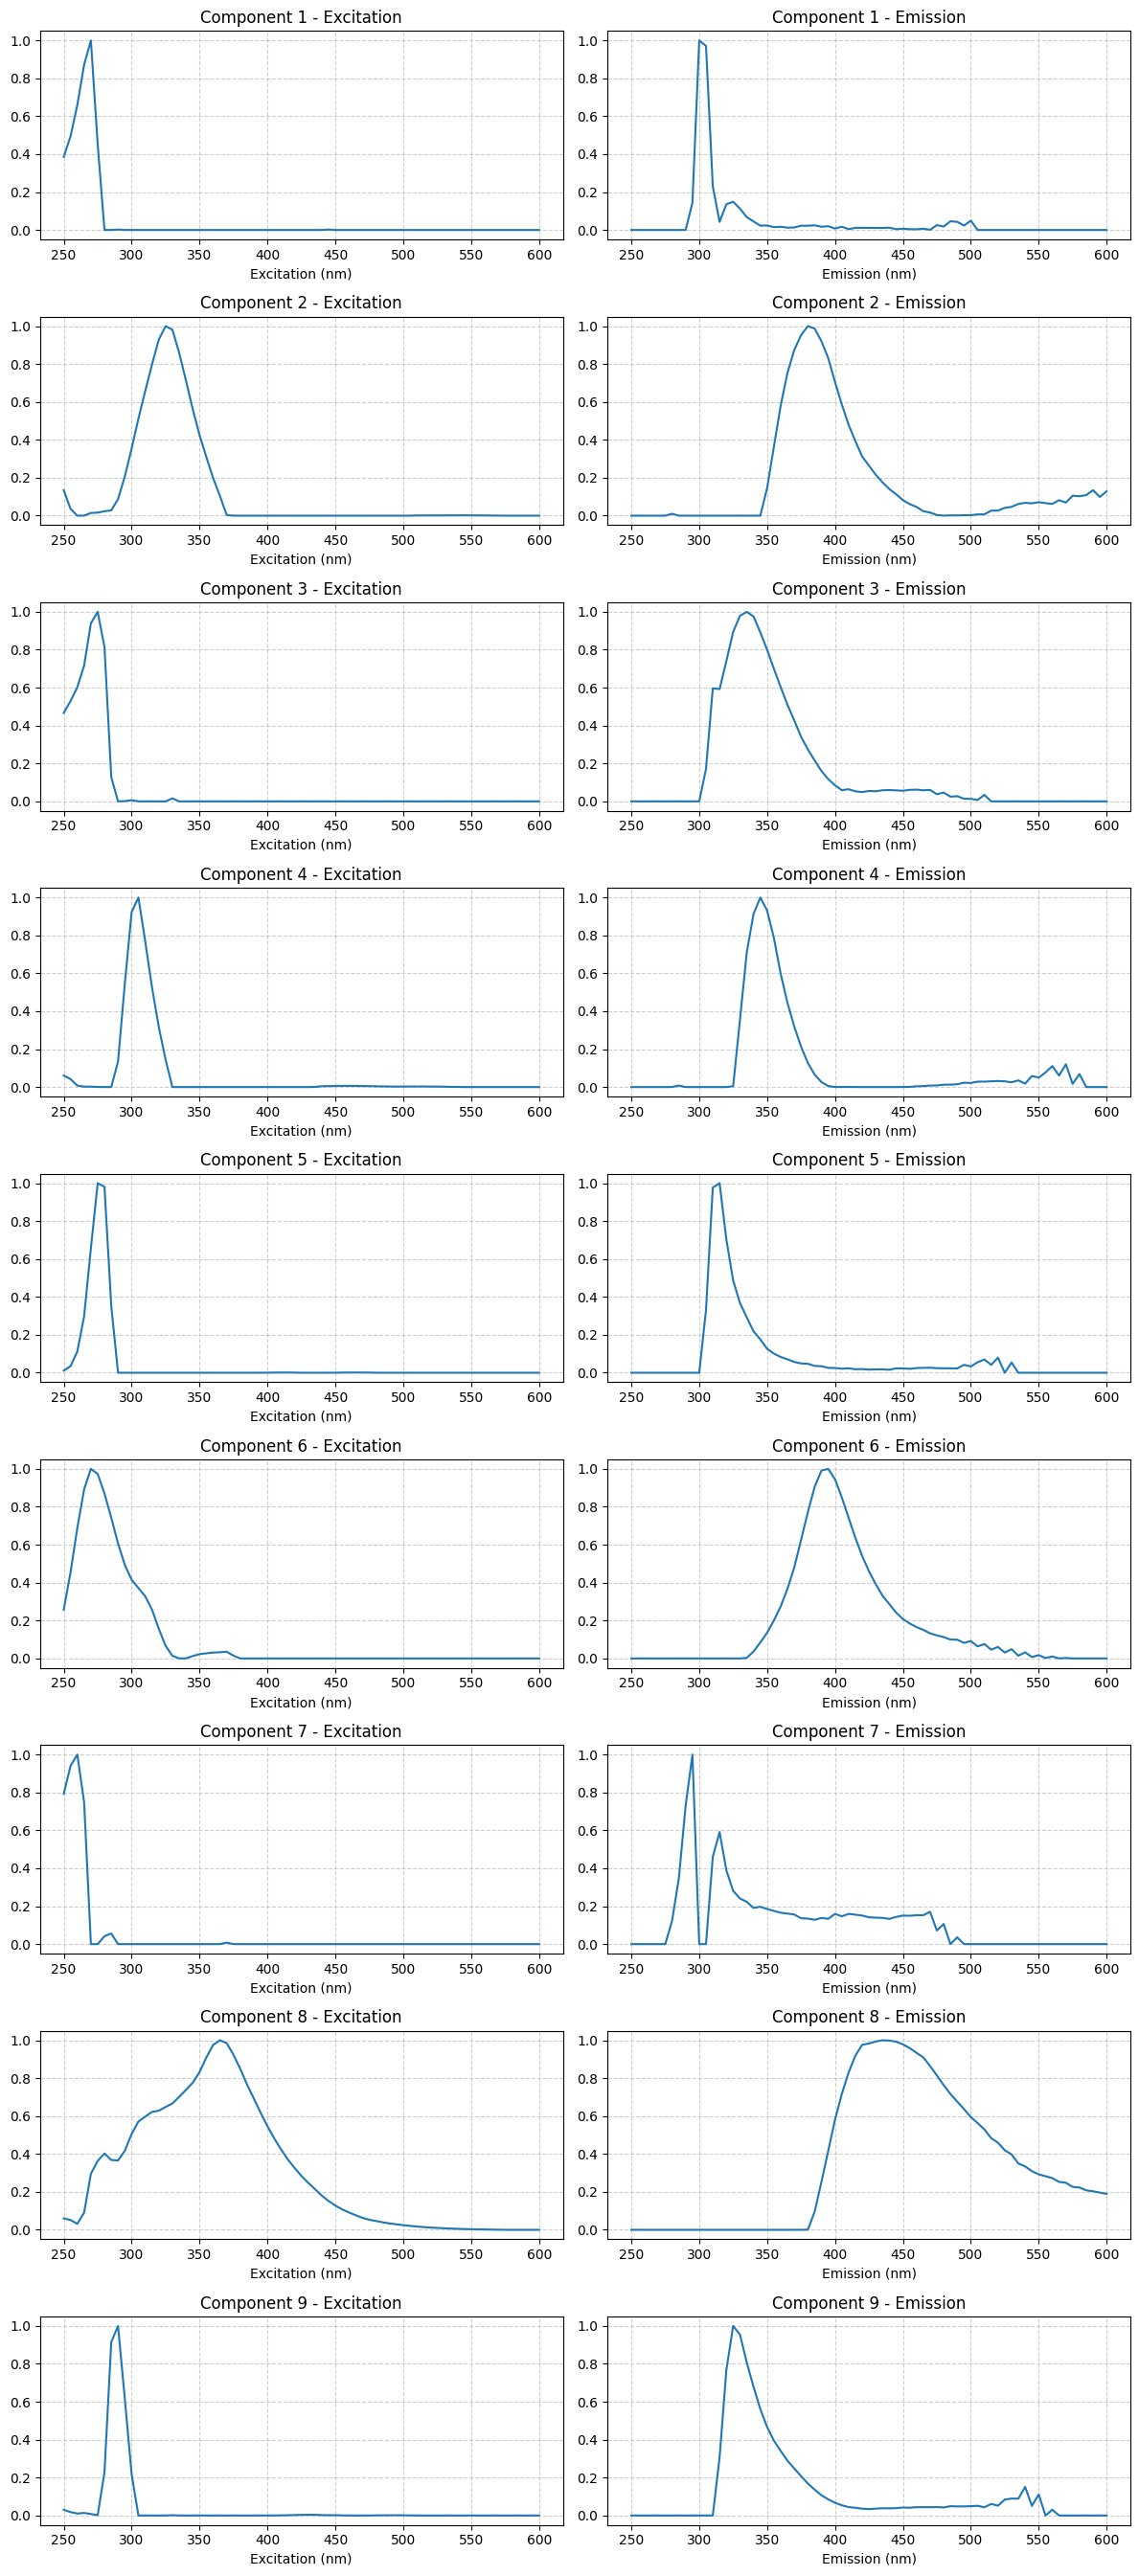


--- 各MPの成分含有量をプロットします ---


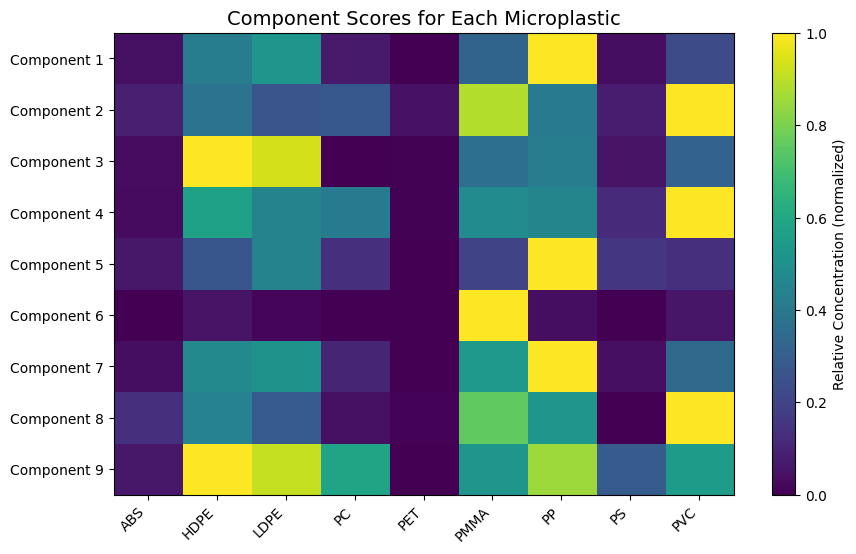

In [30]:
# %% 最終モデルの構築と結果の可視化

import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import matplotlib.pyplot as plt

# --- 最適な成分数を設定 ---
OPTIMAL_COMPONENTS = 9

# --- 事前準備 ---
# NaNを0で埋めた正規化済みデータ
eem_array_imputed = np.nan_to_num(eem_array_normalized, nan=0.0)
# テンソルに変換 (励起, 蛍光, サンプル)
tensor = tl.tensor(np.transpose(eem_array_imputed, (1, 2, 0)))

# --- 最終モデルの計算 ---
print(f"--- 最適な成分数 = {OPTIMAL_COMPONENTS} で最終モデルを構築します ---")
weights, factors = non_negative_parafac(tensor, rank=OPTIMAL_COMPONENTS,
                                        n_iter_max=500, tol=1e-7, init='random')

# --- 結果の分解 ---
# factors は [励起ローディング, 蛍光ローディング, サンプルスコア]
excitation_loadings, emission_loadings, sample_scores = factors

# 各ローディングを最大値で正規化して見やすくする
excitation_loadings_norm = excitation_loadings / np.max(excitation_loadings, axis=0)
emission_loadings_norm = emission_loadings / np.max(emission_loadings, axis=0)
sample_scores_norm = sample_scores / np.max(sample_scores, axis=0)

print("--- モデル構築完了 ---")

# --- 結果の可視化 ---

# 1. 励起・蛍光ローディング（成分のスペクトル形状）のプロット
print("\n--- 抽出された成分のスペクトルをプロットします ---")
fig, axes = plt.subplots(OPTIMAL_COMPONENTS, 2, figsize=(12, 3 * OPTIMAL_COMPONENTS))
for i in range(OPTIMAL_COMPONENTS):
    # 励起ローディング
    axes[i, 0].plot(ex_bands_trimmed, excitation_loadings_norm[:, i])
    axes[i, 0].set_title(f'Component {i+1} - Excitation')
    axes[i, 0].set_xlabel('Excitation (nm)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # 蛍光ローディング
    axes[i, 1].plot(em_bands_trimmed, emission_loadings_norm[:, i])
    axes[i, 1].set_title(f'Component {i+1} - Emission')
    axes[i, 1].set_xlabel('Emission (nm)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()


# 2. サンプルスコア（各MPの成分含有量）のプロット
print("\n--- 各MPの成分含有量をプロットします ---")
plt.figure(figsize=(10, 6))
# ヒートマップで可視化
plt.imshow(sample_scores_norm.T, cmap='viridis', aspect='auto')
plt.yticks(ticks=np.arange(OPTIMAL_COMPONENTS), labels=[f'Component {i+1}' for i in range(OPTIMAL_COMPONENTS)])
plt.xticks(ticks=np.arange(len(sample_name)), labels=sample_name, rotation=45, ha='right')
plt.colorbar(label='Relative Concentration (normalized)')
plt.title('Component Scores for Each Microplastic', fontsize=14)
plt.show()

---

In [32]:
# for data in srcdata:
#     eem = fluorescence_util.EEMF7000(data.get('path'))
#     print(eem)

#     plt.figure()

#     # ① 散乱ピーク除去
#     eem.remove_self_reflection_and_scattering_from_eem(margin_steps=6,
#                                                        remove_first_order=True, 
#                                                        inplace=True)

#     # ② 追加で散乱領域全体を除去
#     eem.remove_scatter_regions(inplace=True)

#     eem.plot_heatmap()
#     plt.title(eem.sample)

sample_data = []
sample_name = []

for data in srcdata:

    # EEMデータの読み込み
    eem = fluorescence_util.EEMF7000(data.get('path'))
    print(eem)

    # ①散乱ピーク除去
    eem.remove_self_reflection_and_scattering_from_eem(margin_steps=6,
                                                       remove_first_order=True,
                                                        inplace=True)
    # ② 追加で散乱領域全体を除去
    eem.remove_scatter_regions(inplace=True)

    # 250nm以上のインデックスを取得
    ex_mask = ex_bands >= 250
    em_mask = em_bands >= 250

    eem_matrix = eem.mat  # numpy配列を取り出す

    # eem_matrix = np.nan_to_num(eem.mat, nan=0.0)
    eem_matrix_trimmed = eem_matrix[np.ix_(ex_mask, em_mask)]

    sample_data.append(eem_matrix_trimmed)
    sample_name.append(eem.sample)

    # eem.plot_heatmap()
    # plt.title(eem.sample)

# numpy配列に保存
eem_array = np.array(sample_data)
print(eem_array.shape)

EEM of "ABS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "HDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "LDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PET"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PMMA"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PP"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PVC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
(9, 71, 71)


## 波長域の調整

In [33]:
ex_mask = np.array(ex_bands) >= 250
em_mask = np.array(em_bands) >= 250

# trim
ex_bands = np.array(ex_bands)[ex_mask]
em_bands = np.array(em_bands)[em_mask]

print("Excitation bands ≥ 250nm:", ex_bands)
print("Emission bands ≥ 250nm:", em_bands)


Excitation bands ≥ 250nm: [250. 255. 260. 265. 270. 275. 280. 285. 290. 295. 300. 305. 310. 315.
 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370. 375. 380. 385.
 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445. 450. 455.
 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515. 520. 525.
 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585. 590. 595.
 600.]
Emission bands ≥ 250nm: [250. 255. 260. 265. 270. 275. 280. 285. 290. 295. 300. 305. 310. 315.
 320. 325. 330. 335. 340. 345. 350. 355. 360. 365. 370. 375. 380. 385.
 390. 395. 400. 405. 410. 415. 420. 425. 430. 435. 440. 445. 450. 455.
 460. 465. 470. 475. 480. 485. 490. 495. 500. 505. 510. 515. 520. 525.
 530. 535. 540. 545. 550. 555. 560. 565. 570. 575. 580. 585. 590. 595.
 600.]


## ノイズありサンプルの生成

### 各MPごとに生成

In [34]:
def augment_eem_per_mp_with_scatter_removal(eem_array, ex_bands, em_bands, n_variants=20, noise_level=0.05, seed=None):
    """
    ノイズ付きEEMを生成し、散乱領域を0にして除去する。

    Parameters:
        eem_array: np.ndarray
            入力EEM配列。shape = (num_MP, n_ex, n_em)
        ex_bands: np.ndarray
            励起波長リスト（shape = n_ex）
        em_bands: np.ndarray
            蛍光波長リスト（shape = n_em）
        n_variants: int
            各MPごとに生成するノイズ付きEEMの数
        noise_level: float
            ノイズのスケール（最大値に対する割合）
        seed: int or None
            乱数シード

    Returns:
        augmented_eems: np.ndarray
            shape = (num_MP, n_variants, n_ex, n_em)
    """
    if seed is not None:
        np.random.seed(seed)

    num_MP, n_ex, n_em = eem_array.shape
    augmented_eems = np.zeros((num_MP, n_variants, n_ex, n_em))

    # 散乱領域マスク（True: 有効領域, False: 散乱 → 0にする）
    ex_grid, em_grid = np.meshgrid(ex_bands, em_bands, indexing='ij')
    valid_mask = (em_grid >= ex_grid) & (em_grid <= 2 * ex_grid)

    for i in range(num_MP):
        base_eem = eem_array[i]
        for j in range(n_variants):
            noise = np.random.normal(loc=0, scale=noise_level * np.max(base_eem), size=base_eem.shape)
            noisy_eem = np.clip(base_eem + noise, 0, None)
            noisy_eem[~valid_mask] = 0  # 散乱領域を0に
            augmented_eems[i, j] = noisy_eem

    return augmented_eems
# ex_bands, em_bands は np.array で定義されていると仮定
augmented_eems = augment_eem_per_mp_with_scatter_removal(
    eem_array,
    ex_bands=ex_bands,
    em_bands=em_bands,
    n_variants=50,
    noise_level=0,
    seed=42
)


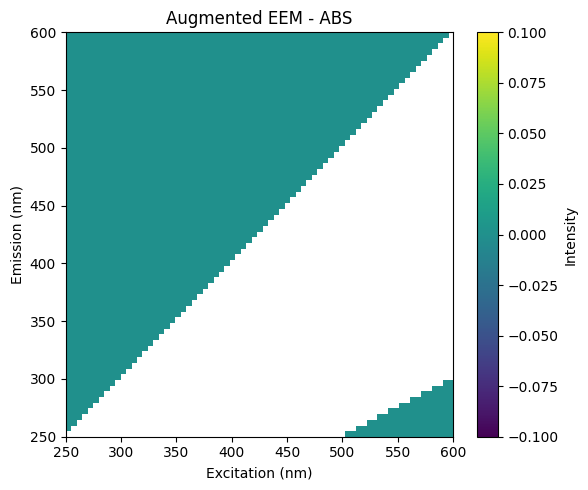

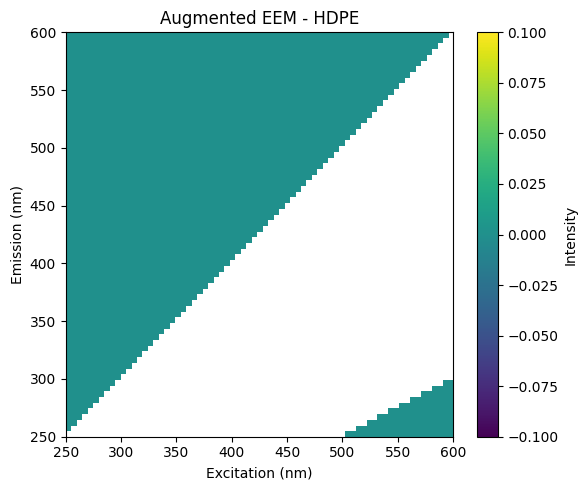

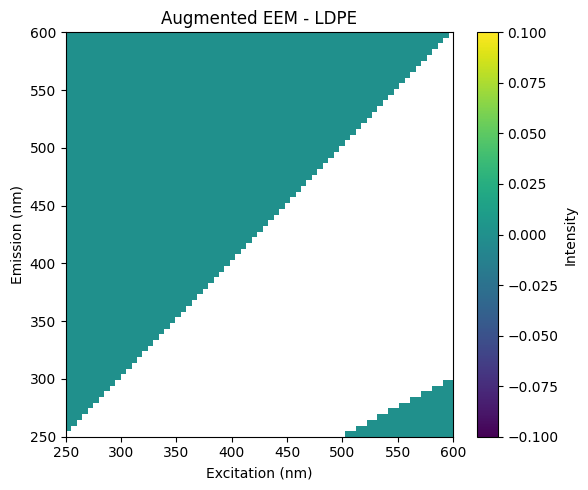

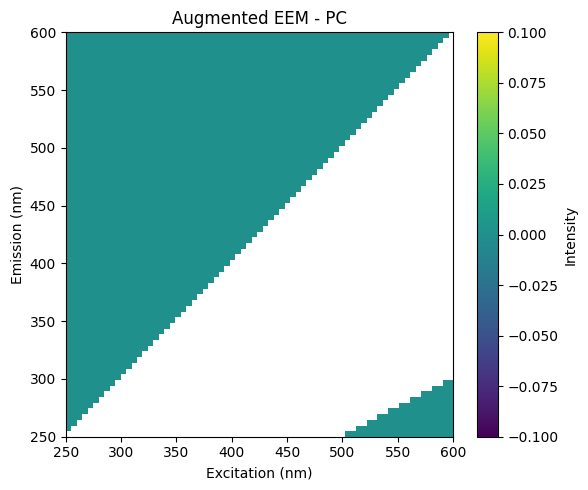

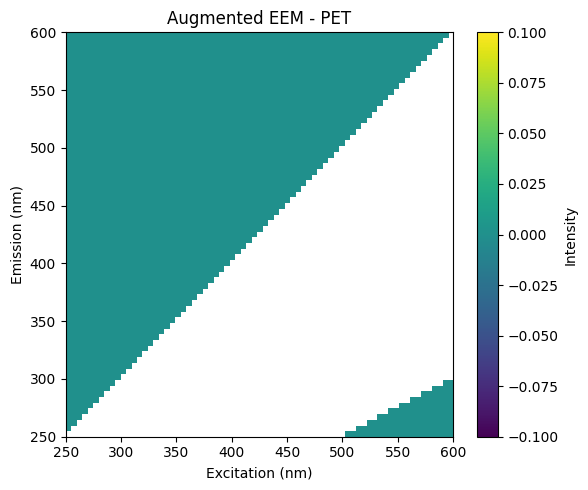

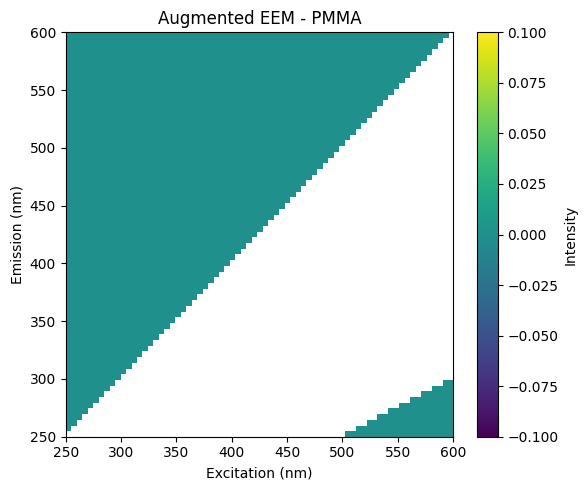

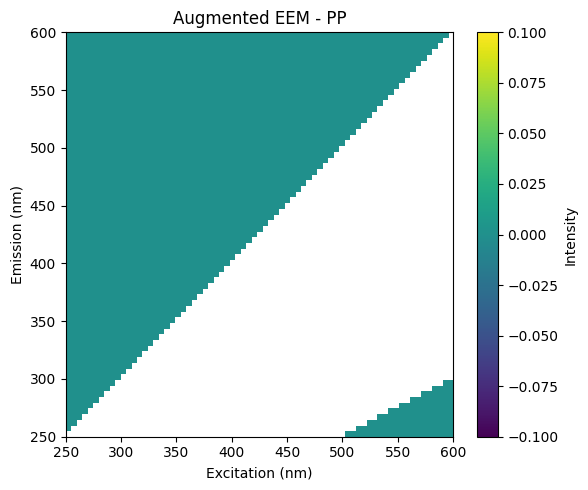

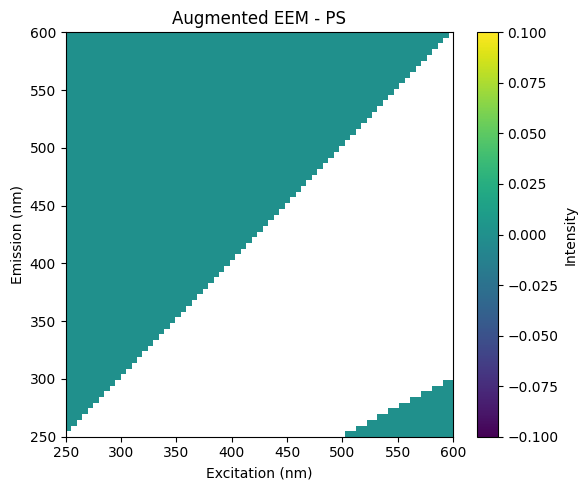

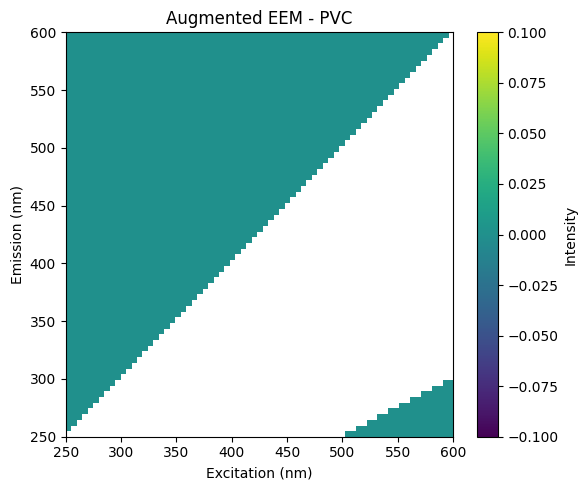

In [35]:
import matplotlib.pyplot as plt

def plot_augmented_eems_one_by_one(augmented_eems, ex_bands, em_bands, sample_names=None):
    """
    各MPから1つずつノイズ付きEEMを、個別にプロット（励起：横軸、放射：縦軸）。

    Parameters:
        augmented_eems: np.ndarray
            shape = (num_MP, n_variants, n_ex, n_em)
        ex_bands: np.ndarray
            励起波長リスト（横軸）
        em_bands: np.ndarray
            発光波長リスト（縦軸）
        sample_names: list or None
            MPごとの名前リスト（任意）
    """
    num_MP = augmented_eems.shape[0]

    for mp_idx in range(num_MP):
        eem = augmented_eems[mp_idx, 0]  # 各MPで最初のノイズバージョンを表示

        plt.figure(figsize=(6, 5))
        plt.imshow(eem, origin='lower',
                   extent=[ex_bands[0], ex_bands[-1], em_bands[0], em_bands[-1]],
                   aspect='auto', cmap='viridis')

        plt.xlabel('Excitation (nm)')
        plt.ylabel('Emission (nm)')
        title = sample_names[mp_idx] if sample_names else f'MP {mp_idx}'
        plt.title(f'Augmented EEM - {title}')
        plt.colorbar(label='Intensity')
        plt.tight_layout()
        plt.show()

plot_augmented_eems_one_by_one(augmented_eems, ex_bands, em_bands, sample_names=sample_name)
# plot_augmented_eems_one_by_one(combined_augmented_eems, ex_bands, em_bands, sample_names=sample_name)


## MPのEEMを合成

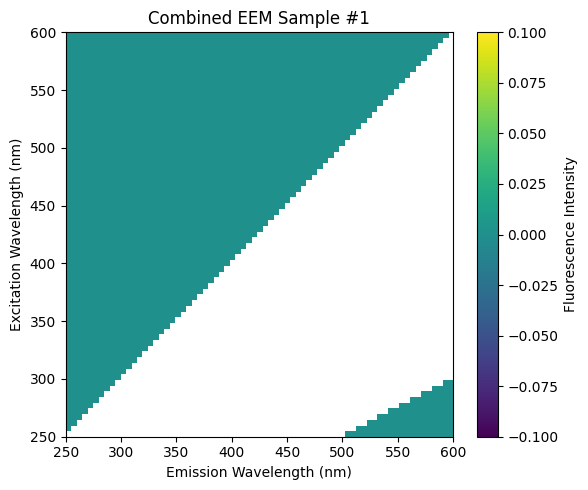

In [36]:
def generate_combined_eem_with_noise(
    eem_array, ex_bands, em_bands,
    n_variants=20, noise_level=0.05, seed=None
):
    """
    全MPのEEMを合成して、ノイズ付きのEEMを生成（散乱領域除去つき）

    Parameters:
        eem_array: np.ndarray
            shape = (num_MP, n_ex, n_em)
        ex_bands: np.ndarray
            励起波長リスト（shape = n_ex）
        em_bands: np.ndarray
            放射波長リスト（shape = n_em）
        n_variants: int
            生成するバリエーション数
        noise_level: float
            ノイズのスケール（合成EEMの最大値に対する割合）
        seed: int or None
            乱数シード

    Returns:
        combined_eems: np.ndarray
            shape = (n_variants, n_ex, n_em)
    """
    if seed is not None:
        np.random.seed(seed)

    # --- 合成EEM（すべてのMPの和）
    combined_base = np.sum(eem_array, axis=0)  # shape = (n_ex, n_em)

    # --- 散乱領域マスクを作成
    ex_grid, em_grid = np.meshgrid(ex_bands, em_bands, indexing='ij')
    valid_mask = (em_grid >= ex_grid) & (em_grid <= 2 * ex_grid)

    # --- ノイズ付きEEMの生成
    combined_eems = np.zeros((n_variants, *combined_base.shape))
    for i in range(n_variants):
        noise = np.random.normal(loc=0, scale=noise_level * np.max(combined_base), size=combined_base.shape)
        noisy_eem = np.clip(combined_base + noise, 0, None)
        noisy_eem[~valid_mask] = 0  # 散乱領域をゼロに
        combined_eems[i] = noisy_eem

    return combined_eems

combined_augmented_eems = generate_combined_eem_with_noise(
    eem_array,
    ex_bands=ex_bands,
    em_bands=em_bands,
    n_variants=50,
    noise_level=0.05,
    seed=123
)


# 1枚目を取得
eem_sample = combined_augmented_eems[0]

# プロット
plt.figure(figsize=(6, 5))
plt.imshow(
    eem_sample,
    aspect='auto',
    origin='lower',
    extent=[em_bands.min(), em_bands.max(), ex_bands.min(), ex_bands.max()],
    cmap='viridis'
)
plt.colorbar(label='Fluorescence Intensity')
plt.xlabel('Emission Wavelength (nm)')
plt.ylabel('Excitation Wavelength (nm)')
plt.title('Combined EEM Sample #1')
plt.tight_layout()
plt.show()


## PARAFAC，Core Consistency，Split half

In [37]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from scipy.stats import pearsonr
from corcondia import corcondia_3d

tl.set_backend('numpy')

# --- PARAFAC結果をすべて保存する関数 ---
def compute_parafac_results(eem_tensor, max_components):
    results = []
    for r in range(1, max_components + 1):
        factors = parafac(eem_tensor, rank=r, init='random', tol=1e-6, n_iter_max=200)
        results.append(factors)
    return results

# --- Core Consistency Diagnostic (正式版 CORCONDIA)
def compute_core_consistency_corcondia(tensor, max_components=7):
    cc_list = []
    for r in range(1, max_components + 1):
        cc = corcondia_3d(tensor, k=r)
        cc_list.append(cc)
    return cc_list

# --- Split-Half 類似度の一括計算（各ランクで別々に分割＋分解）
def compute_split_half_similarities(tensor, max_components):
    sim_list = []
    for r in range(1, max_components + 1):
        all_idx = np.arange(tensor.shape[2])
        np.random.shuffle(all_idx)
        half1 = tensor[:, :, all_idx[:tensor.shape[2] // 2]]
        half2 = tensor[:, :, all_idx[tensor.shape[2] // 2:]]

        f1 = parafac(half1, rank=r, init='random', tol=1e-6, n_iter_max=200)
        f2 = parafac(half2, rank=r, init='random', tol=1e-6, n_iter_max=200)

        ex1, em1, _ = f1.factors
        ex2, em2, _ = f2.factors

        sim_total = 0
        for i in range(r):
            r_ex, _ = pearsonr(ex1[:, i], ex2[:, i])
            r_em, _ = pearsonr(em1[:, i], em2[:, i])
            sim_total += (r_ex + r_em) / 2
        sim_list.append(sim_total / r)
    return sim_list

# --- 各MPに対して Core Consistency（CORCONDIA）と Split-Half 類似度を計算 ---
cc_dict = {}
sh_dict = {}
factors_dict = {}

for idx, eem_tensor in enumerate(augmented_eems):
    sample = sample_name[idx]
    print(f"\n🔍【{sample}】の Core Consistency / Split-Half 計算中...")

    tensor = np.transpose(eem_tensor, (1, 2, 0))  # (exc, em, sample)
    factors_dict[sample] = compute_parafac_results(tensor, max_components=7)

    # 正式な Core Consistency 計算（CORCONDIA）
    cc_dict[sample] = compute_core_consistency_corcondia(tensor, max_components=7)

    # Split-Half 類似度
    sh_dict[sample] = compute_split_half_similarities(tensor, max_components=7)



🔍【ABS】の Core Consistency / Split-Half 計算中...


LinAlgError: SVD did not converge

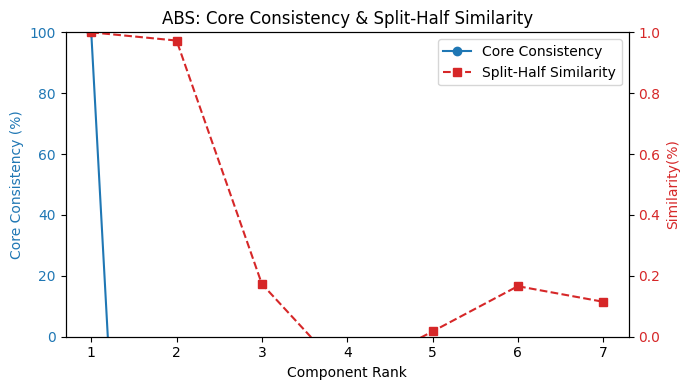

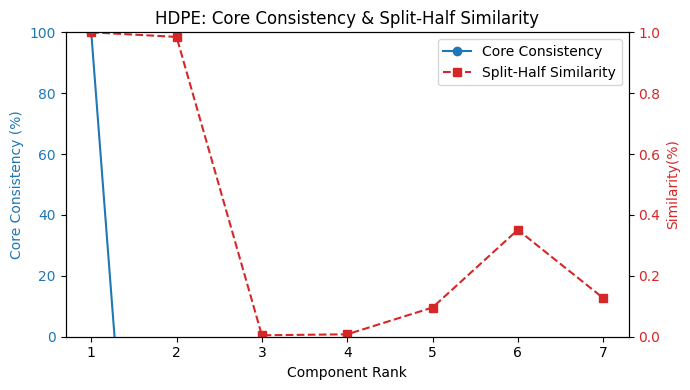

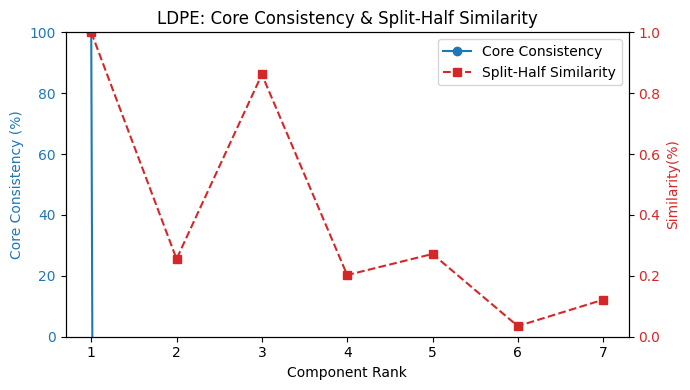

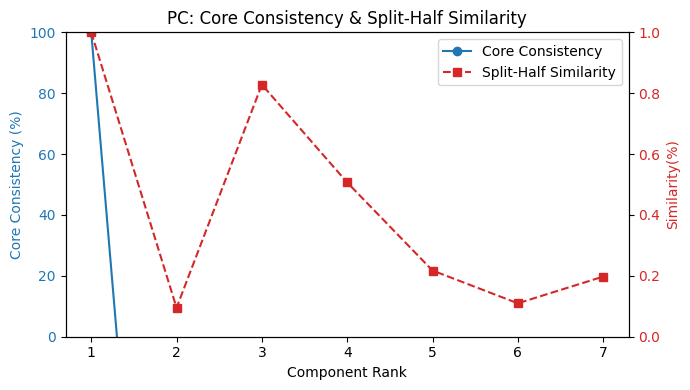

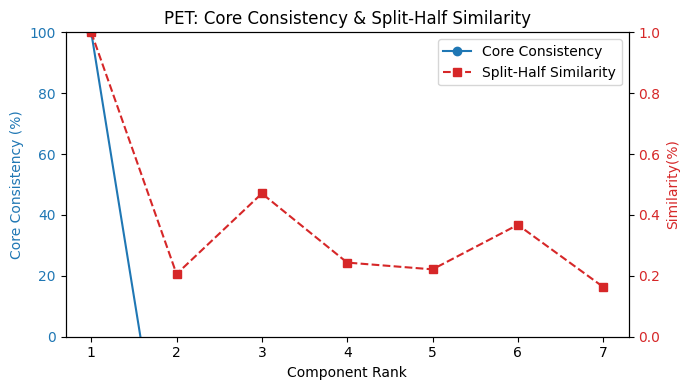

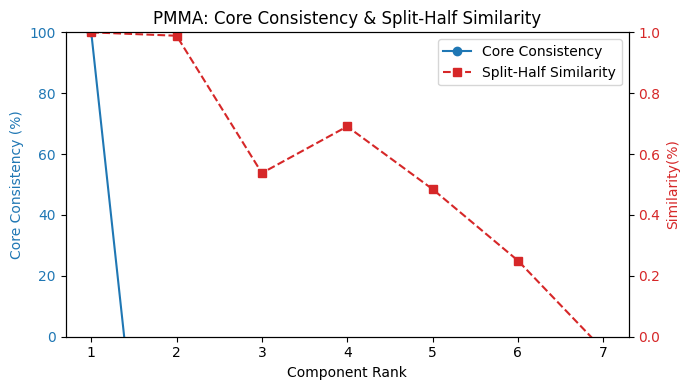

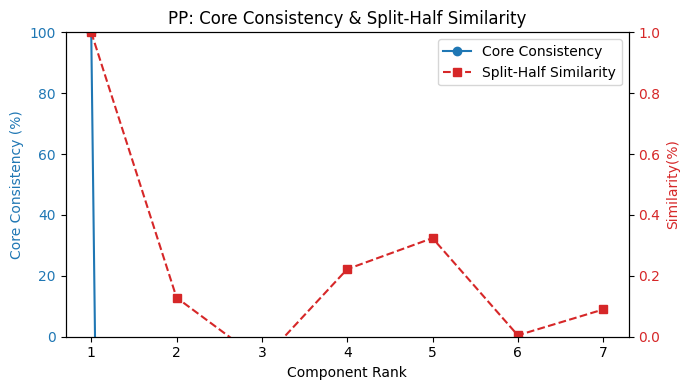

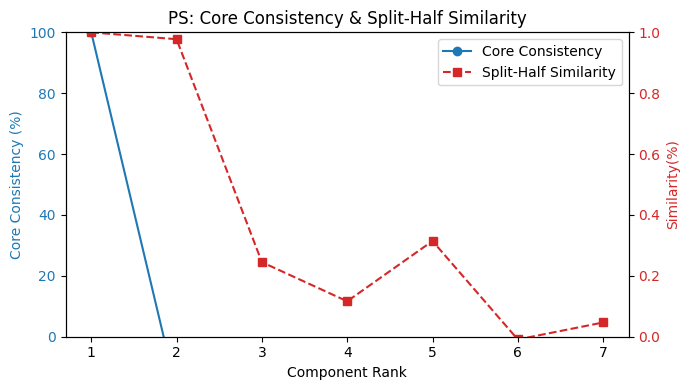

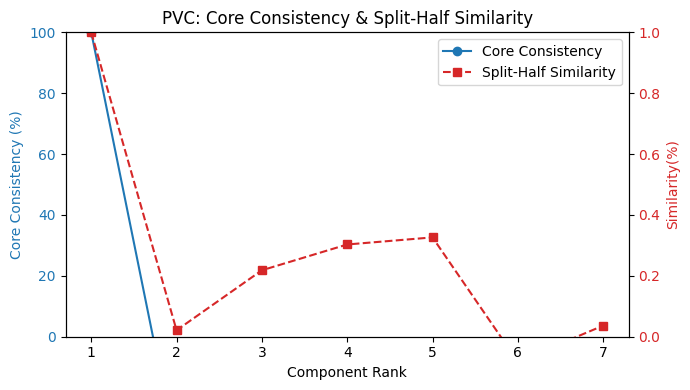

In [ ]:
import matplotlib.pyplot as plt

def plot_core_consistency_and_similarity(cc_list, sh_list, sample_label="Sample", start_rank=1):
    """
    Core ConsistencyとSplit-Half類似度を同時にプロットする関数

    Parameters:
        cc_list: list of float（Core Consistency, 各成分数に対応）
        sh_list: list of float（Split-Half 類似度, 各成分数に対応）
        sample_label: str（プロットタイトル用）
        start_rank: int（通常は1, cc_list[0]がrank=1のとき）
    """
    ranks = list(range(start_rank, start_rank + len(cc_list)))

    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax2 = ax1.twinx()

    ax1.plot(ranks, cc_list, 'o-', color='tab:blue', label='Core Consistency')
    ax2.plot(ranks, sh_list, 's--', color='tab:red', label='Split-Half Similarity')

    ax1.set_xlabel("Component Rank")
    ax1.set_ylabel("Core Consistency (%)", color='tab:blue')
    ax1.set_ylim(0, 100)
    ax2.set_ylabel("Similarity(%)", color='tab:red')
    ax2.set_ylim(0, 1.0)

    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax1.set_title(f"{sample_label}: Core Consistency & Split-Half Similarity")

    # 凡例の設定
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

# for sample in sample_name:
#     plot_core_consistency_and_similarity(cc_list, sh_list, sample_label=sample)
for sample in sample_name:
    cc_list = cc_dict.get(sample)
    sh_list = sh_dict.get(sample)
    if cc_list is not None and sh_list is not None:
        plot_core_consistency_and_similarity(cc_list, sh_list, sample_label=sample)
    else:
        print(f"{sample} の解析結果が見つかりません。")


## コンポーネントの可視化

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_eem_with_bandpass_box(eem, ex_bands, em_bands,
                                excitation_loading, emission_loading,
                                rank, band_width=20, sample_label="MP"):
    """
    ノイズ付きEEM上に、指定コンポーネントのバンドパス波長範囲を紫の四角で重ねて表示

    Parameters:
        eem: 2D array (ex × em)
        ex_bands: 1D array
        em_bands: 1D array
        excitation_loading: 2D array (ex, rank)
        emission_loading: 2D array (em, rank)
        component_idx: int（何番目のコンポーネントか、0始まり）
        band_width: float（±何nmで範囲を取るか）
        sample_label: str
    """

    # EEMをプロット
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(eem, origin='lower',
                   extent=[em_bands[0], em_bands[-1],
                           ex_bands[0], ex_bands[-1]],
                   aspect='auto', cmap='viridis')
    
    for i in range(rank):
        # ピーク波長をローディングから抽出
        exc_idx = np.argmax(excitation_loading[:, i])
        em_idx = np.argmax(emission_loading[:, i])
        exc_peak = ex_bands[exc_idx]
        em_peak = em_bands[em_idx]

        # 四角の範囲（±band_width）
        exc_min = exc_peak - band_width
        exc_max = exc_peak + band_width
        em_min = em_peak - band_width
        em_max = em_peak + band_width

        # # ローディング
        # exc = excitation_loading[:, i]
        # em = emission_loading[:, i]

        # # ピーク位置（最大値）インデックス → 波長
        # exc_idx = np.argmax(exc)
        # em_idx = np.argmax(em)
        # exc_peak = ex_bands[exc_idx]
        # em_peak = em_bands[em_idx]

        # # 🎯 励起ローディングの標準偏差を使って band_width を決める
        # # 重み付き平均と分散（中心波長±幅）
        # exc_mean = np.sum(ex_bands * exc) / np.sum(exc)
        # exc_var = np.sum(((ex_bands - exc_mean) ** 2) * exc) / np.sum(exc)
        # band_width = np.sqrt(exc_var)   # 標準偏差

        # # 四角の範囲（±1σ程度）
        # exc_min = exc_peak - band_width
        # exc_max = exc_peak + band_width
        # em_min = em_peak - band_width
        # em_max = em_peak + band_width

        # 🔴 赤い横線で Excitation peak を示す  
        ax.hlines(y=exc_peak, xmin=em_bands[0], xmax=em_bands[-1], colors='red', linestyles='dashed', linewidth=1.5)

        # # ⬅ ラベルを左に表示（x=最小放射波長 - 少し左にオフセット）
        # ax.text(em_bands[0] - 10, exc_peak, f"Ex = {exc_peak} nm",
        #         color='red', fontsize=10, va='center', ha='right')

        print(f"Loading_{i+1} peak ex_band: {exc_peak}")
        print(f"Loading_{i+1} peak em_band: {em_peak}")
        
        # 紫の四角を重ねる
        rect = patches.Rectangle(
            (em_min, exc_min),  # 左下角 (x, y)
            em_max - em_min,    # 幅
            exc_max - exc_min,  # 高さ
            linewidth=2,
            edgecolor='white',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_title(f"{sample_label} - EEM with Bandpass Box (Component {rank})")
        ax.set_xlabel("Emission Wavelength (nm)")
        ax.set_ylabel("Excitation Wavelength (nm)")
        plt.tight_layout()
    plt.colorbar(im, ax=ax, label="Fluorescence Intensity")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_selected_loadings(factors, rank, ex_bands, em_bands, sample_label="Sample"):
    """
    指定したrankのPARAFAC結果を使って、励起と発光のローディングをプロット

    Parameters:
        results: list of parafac results（compute_parafac_results()の出力）
        rank: int（表示したいコンポーネント数）
        ex_bands: 1D array（励起波長）
        em_bands: 1D array（発光波長）
        sample_label: str（MPの名前など）
    """
    factors_rank = factors[rank - 1]  # インデックス注意：rank=1 → results[0]
    excitation_loading, emission_loading, _ = factors_rank.factors

    # --- 励起ローディング ---
    plt.figure(figsize=(6, 3))
    for i in range(rank):
        plt.plot(ex_bands, excitation_loading[:, i], label=f"Component {i+1}")
    plt.title(f"{sample_label} - Excitation Loading (Rank {rank})")
    plt.xlabel("Excitation Wavelength (nm)")
    plt.ylabel("Loading Strength")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 発光ローディング ---
    plt.figure(figsize=(6, 3))
    for i in range(rank):
        plt.plot(em_bands, emission_loading[:, i], label=f"Component {i+1}")
    plt.title(f"{sample_label} - Emission Loading (Rank {rank})")
    plt.xlabel("Emission Wavelength (nm)")
    plt.ylabel("Loading Strength")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ローディングの帯域図示化
    plot_eem_with_bandpass_box(eem, ex_bands, em_bands,
                            excitation_loading, emission_loading,
                            rank, band_width=20, sample_label=sample
                            )


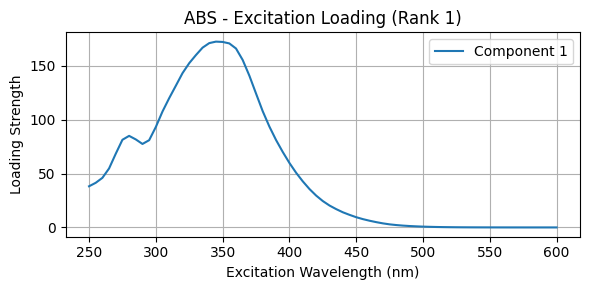

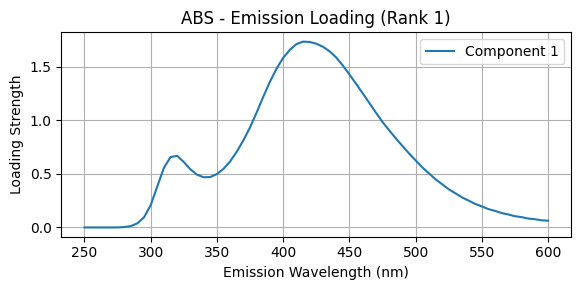

Loading_1 peak ex_band: 345.0
Loading_1 peak em_band: 415.0


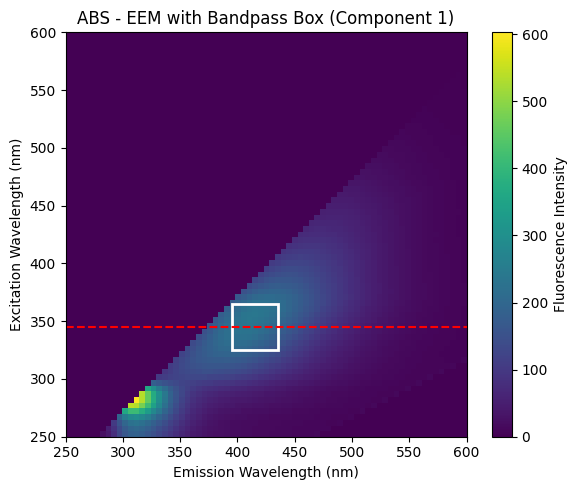

In [ ]:
sample = "ABS"
rank = 1
factors = factors_dict.get(sample)

mp_idx = sample_name.index(sample)  # "PET" に対応するインデックス（例：0）
eem = augmented_eems[mp_idx, 0]  # PETの最初のノイズ付きEEM（shape: 81x81）


if factors is not None:
    plot_selected_loadings(
        factors, 
        rank,
        ex_bands,
        em_bands,
        sample_label=sample
    )
else:
    print(f"{sample} の解析結果が見つかりません。")



---